In [313]:
from atari_dreamerv3 import Atari
import dreamerv3_wrappers as wrappers

In [314]:
import numpy as np
from post_processing_obs import blackout_obs_mode, crop_obs_mode
from ram_modification_obs import ram_obs_modification_mode
from gymnasium.core import ActionWrapper
import random


class PartialObservationWrapper(wrappers.CutomGymnasiumWrapper):
    """Custom wrapper that modifies observations"""
    
    def __init__(self, env, config):
        super().__init__(env)
        self.config = config
        # Replace the _screen method from Atari env
        self.env._screen = self._screen
        self.manipulation = True # if false, returns original _screen behavior

    def _manipulate_screen(self, array):
        """Modify the screen in buffer"""

        # add a random probability to apply the modification
        if np.random.rand() < self.config['prob']:
            if self.config['type'] == 'blackout':
                blackout_obs_mode(array, self.config['mode'])
            elif self.config['type'] == 'crop':
                crop_obs_mode(array, self.config['mode'])
            elif self.config['type'] == 'ram':
                array = ram_obs_modification_mode(self.env._env, self.config['mode'])
    
    def _screen(self, array):
        self.env._ale.getScreenRGB(array)
        if self.manipulation:
            self._manipulate_screen(array)

    # def render(self):
    #     """Override render to show the modified observation"""
    #     if self.render_mode == "rgb_array":
    #         # Get the current observation and apply our modification
    #         obs = self.env.render()
    #         if obs is not None:
    #             return self.observation(obs)
    #     return self.env.render()


class ActionDependentStochasticityWrapper(ActionWrapper):
    """Wrapper that implements action dependent stochasticity in internal ale _env.
    """

    def __init__(self, env, config):
        super().__init__(env)
        self.prob = config['stochastic_action_prob']

    def action(self, action):
        if np.random.random() < self.prob:
            # Choose random action
            return self.env.action_space.sample()
        else:
            # Use predicted action
            return action


class ActionIndependentRandomStochasticityWrapper(ActionWrapper):
    """Wrapper that implements action independent random stochasticity in internal ale _env.

    Note: Does not revert the score on screen.

    Modes:
       mode '0': No stochasticity.
       mode '1': Block hit cancel - if a block is hit, the RAM is reverted to the previous state, effectively canceling the block hit.
       mode '2': Block hit cancel (reward reverted) - if a block is hit, the RAM is reverted to the previous state, effectively canceling the block hit.
       mode '3': Regenerate hit block - after a block is hit, with some probability, a randomly picked block RAM index is reverted to its original value, regenerating a block.
    """

    def __init__(self, env, config):
        super().__init__(env)
        self.mode = config['mode']
        self.prob = config['random_stochasticity_prob']

    def _block_hit_cancel(self, action, cancel_reward=True, verbose=False):
        """
        Takes affect if modified, in the next step.
        If cancel_reward is True, the reward is set to 0 if block hit is cancelled.
        """
        self.previous_ram_state = self.env.unwrapped.ale.getRAM()
        obs, reward, done, info = self.env.step(action)
        current_ram_state = self.env.unwrapped.ale.getRAM()
        if any(current_ram_state[:36] != self.original_ram_state[:36]):
            changed_indices = [i for i in range(36) if current_ram_state[i] != self.previous_ram_state[i]]
            if len(changed_indices) > 0 and random.random() < self.prob:
                for i in changed_indices:
                    self.env.unwrapped.ale.setRAM(i, self.previous_ram_state[i])
                ## reset scores and lives to previous state (does not work)
                # for i in range(81,91):
                #     if verbose:
                #         print(f"resetting {i} to {self.previous_ram_state[i]} from {current_ram_state[i]}")
                #     self.env.unwrapped.ale.setRAM(i, self.previous_ram_state[i])
                if verbose:
                    print(f"block hit cancelled")
                if cancel_reward:
                    reward = 0.0
                    if verbose:
                        print(f"reward reverted to 0")
        return obs, reward, done, info

    def _regenerate_hit_block(self, action, verbose=False):
        """
        Takes affect if modified, in the next step.
        """
        obs, reward, done, info = self.env.step(action)
        current_ram_state = self.env.unwrapped.ale.getRAM()
        # list of indices that changed
        changed_indices = [i for i in range(36) if current_ram_state[i] != self.original_ram_state[i]]
        # randomly choose a changed index and update its value to the original value
        if len(changed_indices) > 0 and random.random() < self.prob:
            random_index = random.choice(changed_indices)
            self.env.unwrapped.ale.setRAM(random_index, self.original_ram_state[random_index])
            if verbose:
                print(f"hit block regenerated")
        return obs, reward, done, info

    def reset(self, seed=None, options=None):
        obs = self.env.reset(seed=seed, options=options)
        self.original_ram_state = self.env.unwrapped.ale.getRAM()
        return obs

    def step(self, action):
        if self.mode == '0':
            return self.env.step(action)
        elif self.mode == '1':
            return self._block_hit_cancel(action, cancel_reward=False, verbose=True)
        elif self.mode == '2':
            return self._block_hit_cancel(action, cancel_reward=True, verbose=True)
        elif self.mode == '3':
            return self._regenerate_hit_block(action)


class ActionIndependentConceptDriftWrapper(wrappers.CutomGymnasiumWrapper):
    """
    Wrapper that implements action independent concept drift in the environment.

    Modes:
        temporal_mode 'sudden': The environment concept (stochasticity type) switches suddenly after a fixed number of steps (temporal_threshold).
        temporal_mode 'cyclic': The environment concept alternates cyclically every temporal_threshold steps between the original and secondary concept.

    Args:
        env: The environment to wrap.
        config: Dictionary with keys:
            - 'temporal_mode': 'sudden' or 'cyclic'
            - 'temporal_threshold': Number of steps before switching concepts
            - 'secondary_concept_type': The stochasticity type to switch to
        StochasticEnv_instance: An instance that manages the stochastic environment and can update its type.
    """
    def __init__(self, env, config, StochasticEnv_instance):
        super().__init__(env)
        self._step_count = 0
        self.current_cycle = 0
        self.temporal_mode = config['temporal_mode']
        self.temporal_threshold = config['temporal_threshold']
        self.secondary_concept_type = config['secondary_concept_type']
        self.StochasticEnv_instance = StochasticEnv_instance

    def update_env_concept(self):
        print(f"updating env concept to stochasticity type: {self.secondary_concept_type}")
        if self.secondary_concept_type == 3:
            raise RecursionError("`Concept drift` is not supported for secondary concept")
        if self.secondary_concept_type == 4:
            raise ValueError("`Partial observation` is the initial concept")
        self.StochasticEnv_instance.type = self.secondary_concept_type
        self.env = self.StochasticEnv_instance.get_env(self.env)

    def revert_env_concept(self):
        print(f"reverting to original concept")
        if hasattr(self.env, 'manipulation'):
            print(f"reverting to original screen")
            self.env.manipulation = False
        if hasattr(self.env, 'env'):
            self.env = self.env.env # for type 5
        else:
            self.env._env = self.env._env.env # for type 1, 2

    def get_cycle(self):
        if self.temporal_mode == 'cyclic':
            return 0 if (self._step_count // self.temporal_threshold) % 2 == 0 else 1
        else:
            return 0

    def step(self, action):

        if self.temporal_mode == 'sudden':
            if self._step_count == self.temporal_threshold - 1:
                self.update_env_concept()

        elif self.temporal_mode == 'cyclic': # currently bi-cyclic
            _cycle = self.get_cycle()
            if _cycle != self.current_cycle:
                if self.current_cycle == 0:
                    self.update_env_concept()
                else:
                    self.revert_env_concept()
                self.current_cycle = _cycle

        obs, reward, done, info = self.env.step(action)
        self._step_count += 1
        return obs, reward, done, info

    def reset(self, *args, **kwargs):
        obs = self.env.reset(*args, **kwargs)
        self._step_count = 0
        return obs


class StochasticEnv:
    """
    Environment type docstrings:

    0: Deterministic Env
       - No stochasticity or partial observability applied.

    1: Intrinsic Stochastic Env (action-dependent)
       - Stochasticity is introduced based on the agent's actions.

    2: Intrinsic Stochastic Env (action-independent-random, Aleatoric)
       - Stochasticity is introduced independently of the agent's actions, e.g., random effects. # block not hit, regen

    3: Intrinsic Stochastic Env (action-independent-concept-drift)
       - Stochasticity is introduced by changing environment dynamics over time (concept drift). # within episode and combine sudden and cyclic

    4: Partially observed Env (state-variable-different-repr)
       - The environment state is partially observed by representing state variables differently.

    5: Partially observed Env (state-variable-missing)
       - The environment state is partially observed by omitting some state variables.
    """
    def __init__(self, type, config):
        self.type = type
        self.config = config

    def get_env(self, env):
        if self.type == 0:
            raise NotImplementedError
        elif self.type == 1:
            env._env = ActionDependentStochasticityWrapper(env._env, config=self.config['intrinsic_stochasticity']['action_dependent'])
            return env
        elif self.type == 2:
            env._env = ActionIndependentRandomStochasticityWrapper(env._env, config=self.config['intrinsic_stochasticity']['action_independent_random'])
            return env
        elif self.type == 3:
            return ActionIndependentConceptDriftWrapper(env, config=self.config['intrinsic_stochasticity']['action_independent_concept_drift'], StochasticEnv_instance=self)
        elif self.type == 4:
            return env
        elif self.type == 5:
            return PartialObservationWrapper(env, config=self.config['partial_observation'])

In [315]:
import matplotlib.pyplot as plt
import numpy as np

def plot_frame(obs, label=''):
    """Plot a frame without going into interactive mode"""
    # Create a new figure with non-interactive backend for this plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(obs)
    ax.set_title(f'Observation {label}')
    ax.axis('off')
    plt.tight_layout()
    plt.show(block=True)  # Don't block, just display
    plt.close()  # Close the figure to free memory

In [316]:
env = Atari(
            'Breakout',
            4,
            [64, 64],
            gray=False,
            noops=0,
            lives='unused',
            sticky=False,
            actions='needed',
            resize='opencv',
            seed=0,
        )

stochasticity_config = {
    'intrinsic_stochasticity': {
        'action_dependent': {
            'stochastic_action_prob': 1.0,
            },
        'action_independent_random': {
            'mode': '2',
            'random_stochasticity_prob': 0.25, # mode 3: keep around 0.0005
        },
        'action_independent_concept_drift': {
            'temporal_mode': 'cyclic', # 'sudden' or 'cyclic'
            'temporal_threshold': 5,
            'secondary_concept_type': 1,
        },
    },
    'partial_observation': {
            'type': 'blackout', # 'blackout' or 'crop' or 'ram'
            'mode': '2', # mode 1 in ram is buggy
            'prob': 1.0,
    },
}

stochasticity_wrapper = StochasticEnv(type=3, config=stochasticity_config)
env = stochasticity_wrapper.get_env(env)

In [317]:
env = wrappers.OneHotAction(env)
env = wrappers.TimeLimit(env, duration=108000)
env = wrappers.SelectAction(env, key="action")
env = wrappers.UUID(env)

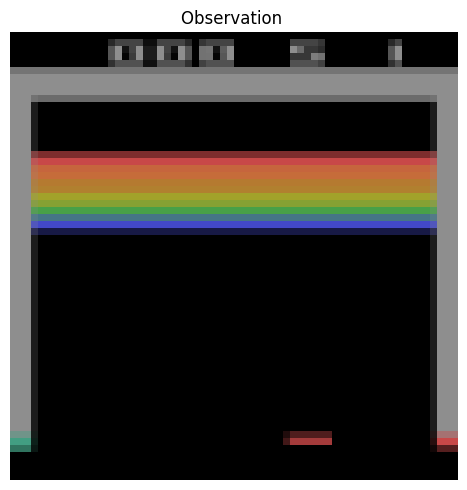

In [318]:
state = env.reset()
state.keys()
plot_frame(state['image'])

33


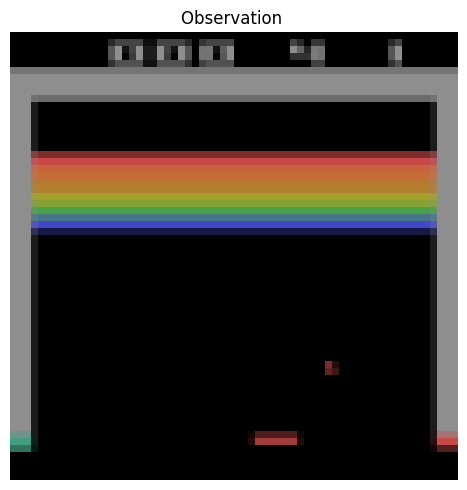

In [351]:
state, reward, is_last, _ = env.step({'action': np.array([0, 1 , 0, 0])})
print(env.env.env.env.env._step_count)
plot_frame(state['image'])